In [3]:
import os
import gc 
import ctypes
import random
import time
import string
import re
from tqdm import tqdm
import pickle

import pandas as pd, numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

import warnings 
warnings.filterwarnings('ignore')

C:\Users\shakr\AppData\Local\Temp\ipykernel_28792\3264808582.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd, numpy as np


In [4]:
class CFG:
    SEED = 2024
    VER = 1
    LOAD_MODELS_FROM = None
    LOAD_FEATURES_FROM = None

In [5]:
df = pd.read_csv('./data/survey-lung-cancer.csv')
print('DataFrame Shape: ', df.shape)
print(display(df))

DataFrame Shape:  (309, 16)


,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,F,56,1,1,1,2,2,2,1,1,2,2,2,2,1,YES
305,M,70,2,1,1,1,1,2,2,2,2,2,2,1,2,YES
306,M,58,2,1,1,1,1,1,2,2,2,2,1,1,2,YES
307,M,67,2,1,2,1,1,2,2,1,2,2,2,1,2,YES


None


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

In [7]:
## numerical columns
numerical_column = df.select_dtypes(include=['int64']).columns
df[numerical_column]  = df[numerical_column] - 1 # 2 -> 1
df['AGE'] = df['AGE'] + 1

In [8]:
## categorical columns
categorical_column = df.select_dtypes(include=['object','category']).columns
print(categorical_column)

Index(['GENDER', 'LUNG_CANCER'], dtype='object')


In [9]:
## Mapping[gender, lung_cancer]
MAP1 = {'F': 0, 'M':1}
MAP2 = {'NO': 0, 'YES':1}

df['GENDER'] = df['GENDER'].map(MAP1)
df['LUNG_CANCER'] = df['LUNG_CANCER'].map(MAP2)

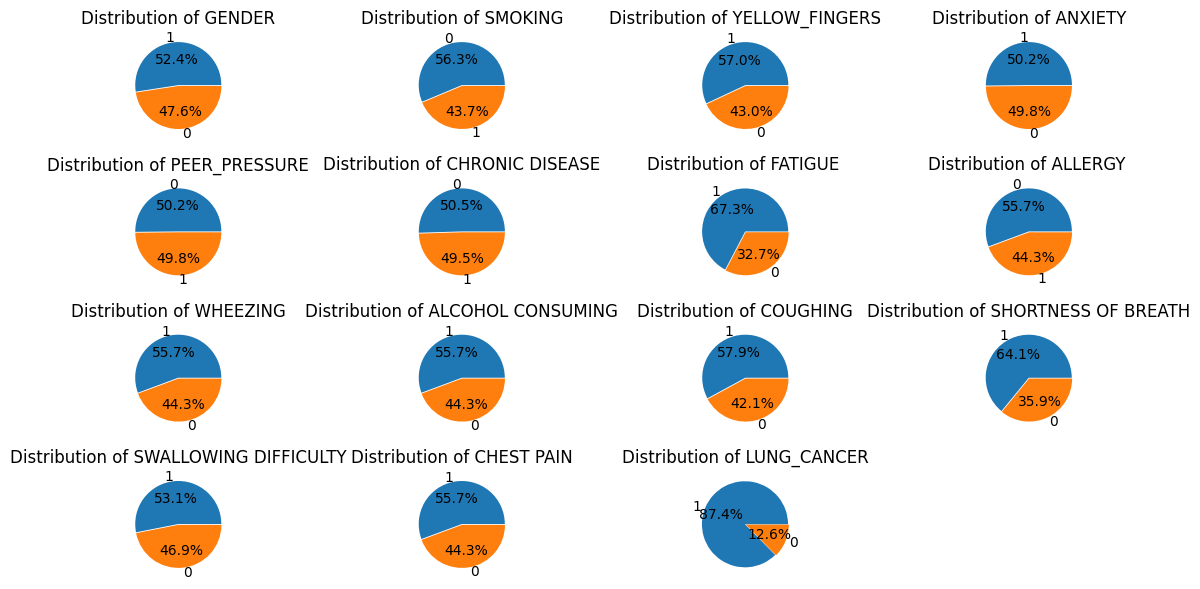

In [10]:
## EDA
plt.figure(figsize=(12,6))
ROWS = 4; COLS = 4

explode = (0.01, 0.01)


for idx, col in enumerate([col for col in df.columns if col !='AGE']):
    plt.subplot(ROWS,COLS,idx+1)
    labels = df[col].unique()
    plt.pie(df[col].value_counts(), labels=labels, explode=explode, autopct='%.1f%%')
    plt.title(f'Distribution of {col}') 

plt.tight_layout()
plt.show()

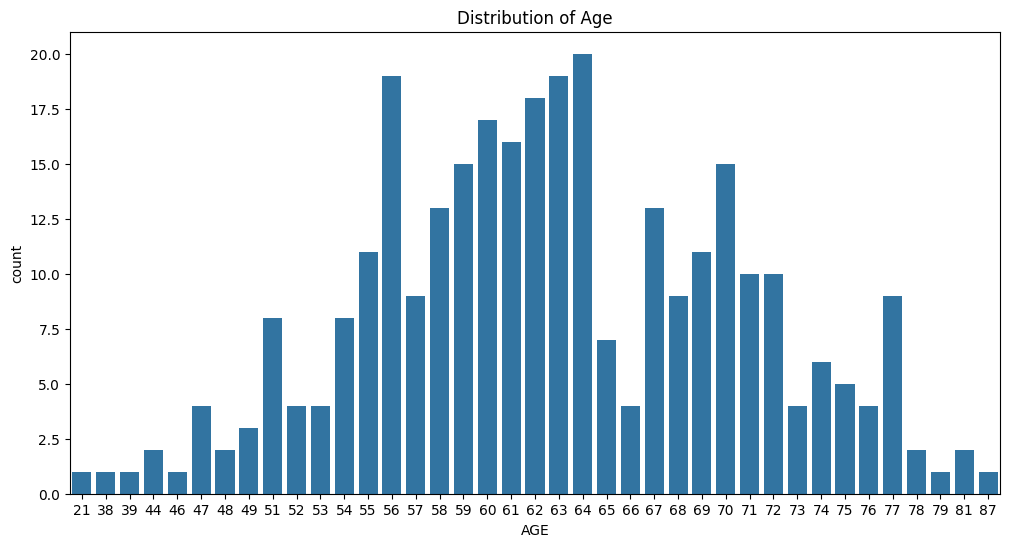

In [11]:
plt.figure(figsize=(12,6))
plt.title('Distribution of Age')
sns.countplot(x=df['AGE'])
plt.show()

In [12]:
## Age Distribution (For GroupKFold)
def age_distribution(row):
    if row <=50:
        return 0
    elif (row >50) & (row <=60):
        return 1
    elif (row >60) & (row<=70):
        return 2
    else:
        return 3
df['AGE_GROUP'] = df['AGE'].apply(lambda x: age_distribution(x))

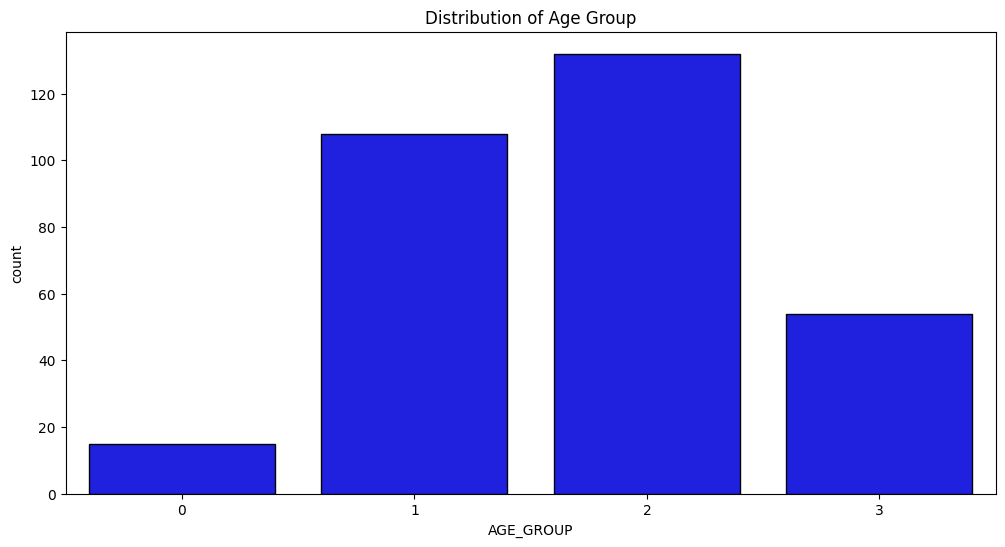

In [13]:
plt.figure(figsize=(12,6))
plt.title('Distribution of Age Group')
sns.countplot(x=df['AGE_GROUP'], color='blue', edgecolor='black')
plt.show()

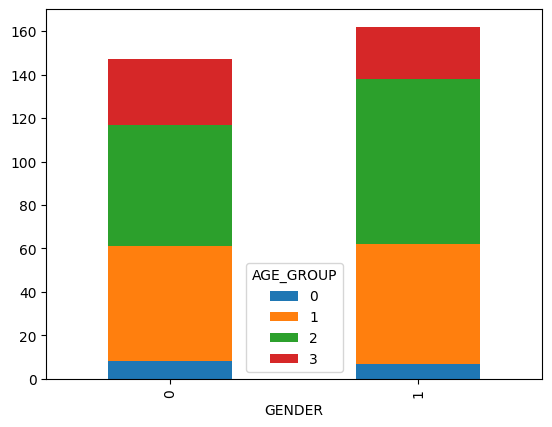

In [14]:
tmp = df.groupby(['GENDER', 'AGE_GROUP']).size().unstack()
tmp.plot(kind='bar', stacked=True)
plt.show()

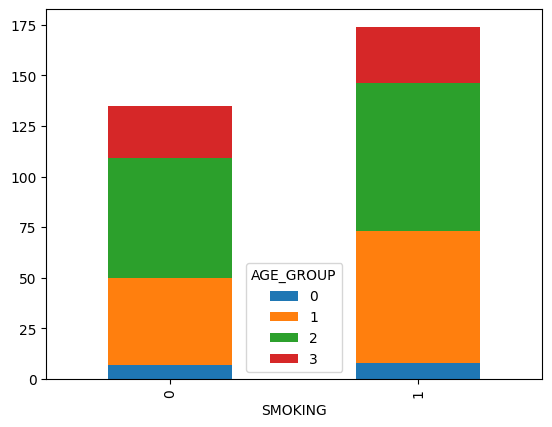

In [15]:
tmp = df.groupby(['SMOKING', 'AGE_GROUP']).size().unstack()
tmp.plot(kind='bar', stacked=True)
plt.show()

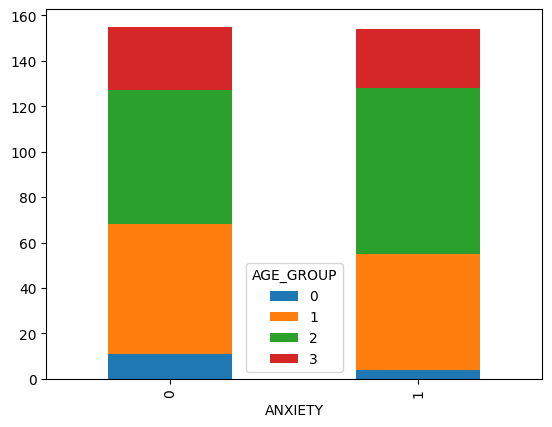

In [16]:
tmp = df.groupby(['ANXIETY', 'AGE_GROUP']).size().unstack()
tmp.plot(kind='bar', stacked=True)
plt.show()

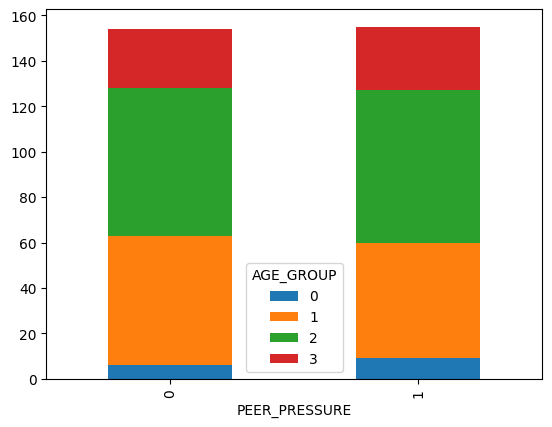

In [17]:
tmp = df.groupby(['PEER_PRESSURE', 'AGE_GROUP']).size().unstack()
tmp.plot(kind='bar', stacked=True)
plt.show()

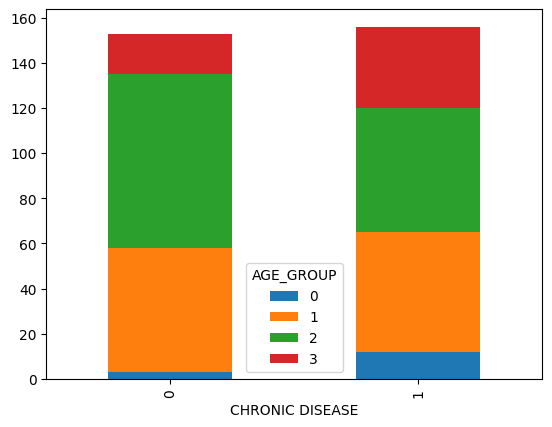

In [18]:
tmp = df.groupby(['CHRONIC DISEASE', 'AGE_GROUP']).size().unstack()
tmp.plot(kind='bar', stacked=True)
plt.show()

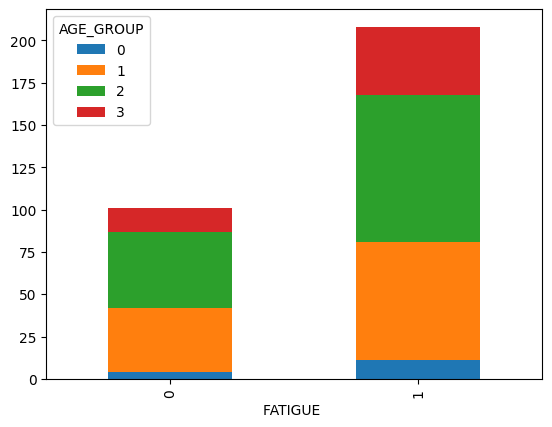

In [19]:
tmp = df.groupby(['FATIGUE ', 'AGE_GROUP']).size().unstack()
tmp.plot(kind='bar', stacked=True)
plt.show()

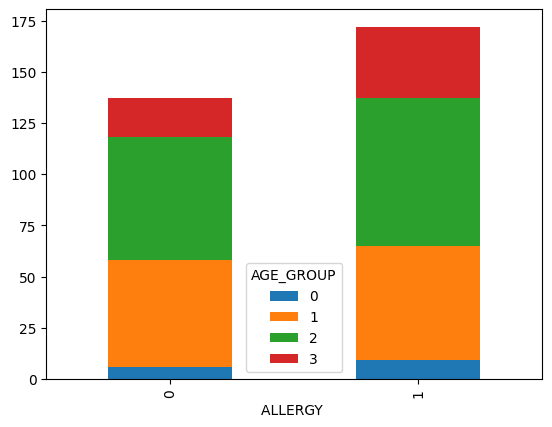

In [20]:
tmp = df.groupby(['ALLERGY ', 'AGE_GROUP']).size().unstack()
tmp.plot(kind='bar', stacked=True)
plt.show()

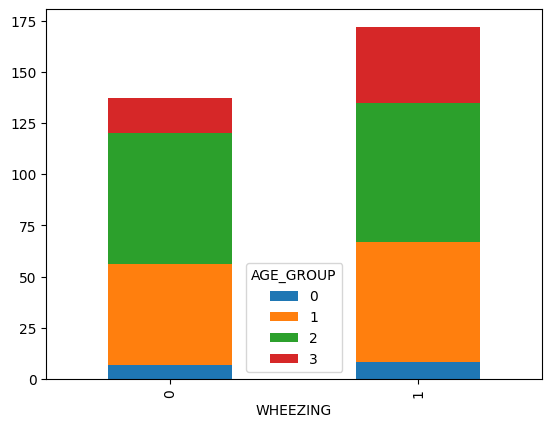

In [21]:
tmp = df.groupby(['WHEEZING', 'AGE_GROUP']).size().unstack()
tmp.plot(kind='bar', stacked=True)
plt.show()

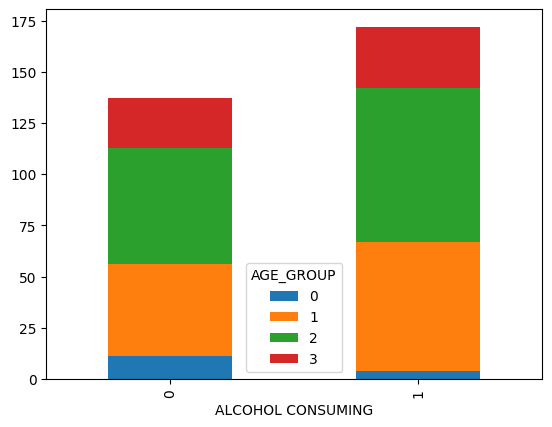

In [22]:
tmp = df.groupby(['ALCOHOL CONSUMING', 'AGE_GROUP']).size().unstack()
tmp.plot(kind='bar', stacked=True)
plt.show()

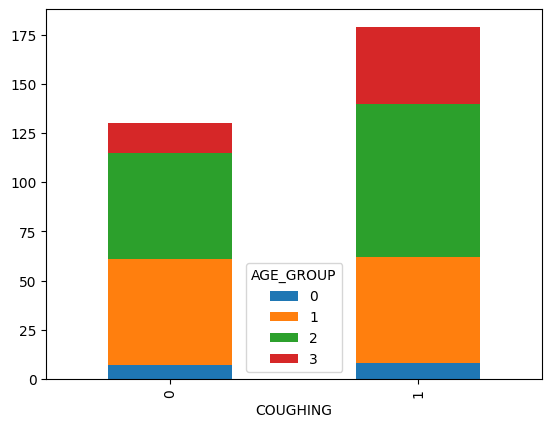

In [23]:
tmp = df.groupby(['COUGHING', 'AGE_GROUP']).size().unstack()
tmp.plot(kind='bar', stacked=True)
plt.show()

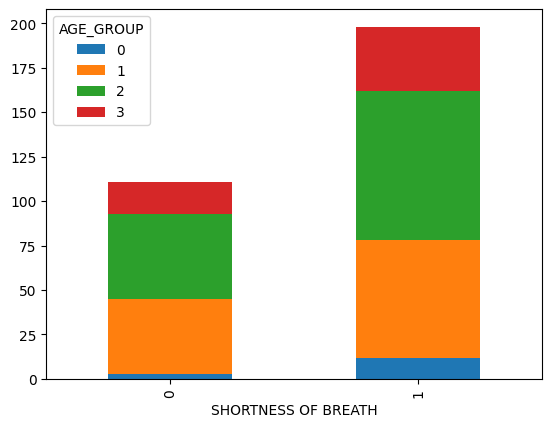

In [24]:
tmp = df.groupby(['SHORTNESS OF BREATH', 'AGE_GROUP']).size().unstack()
tmp.plot(kind='bar', stacked=True)
plt.show()

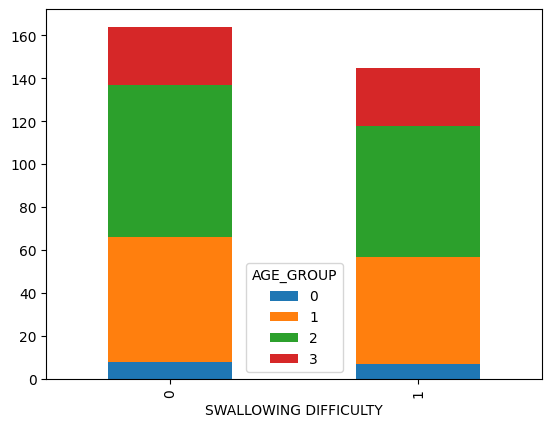

In [25]:
tmp = df.groupby(['SWALLOWING DIFFICULTY', 'AGE_GROUP']).size().unstack()
tmp.plot(kind='bar', stacked=True)
plt.show()

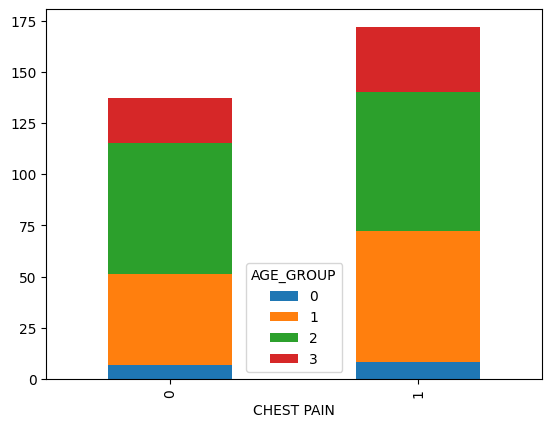

In [26]:
tmp = df.groupby(['CHEST PAIN', 'AGE_GROUP']).size().unstack()
tmp.plot(kind='bar', stacked=True)
plt.show()

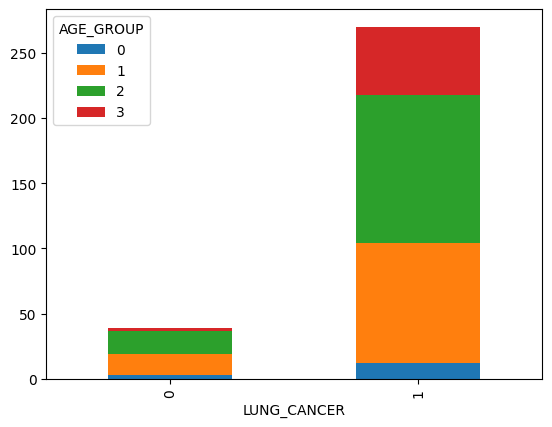

In [27]:
tmp = df.groupby(['LUNG_CANCER', 'AGE_GROUP']).size().unstack()
tmp.plot(kind='bar', stacked=True)
plt.show()

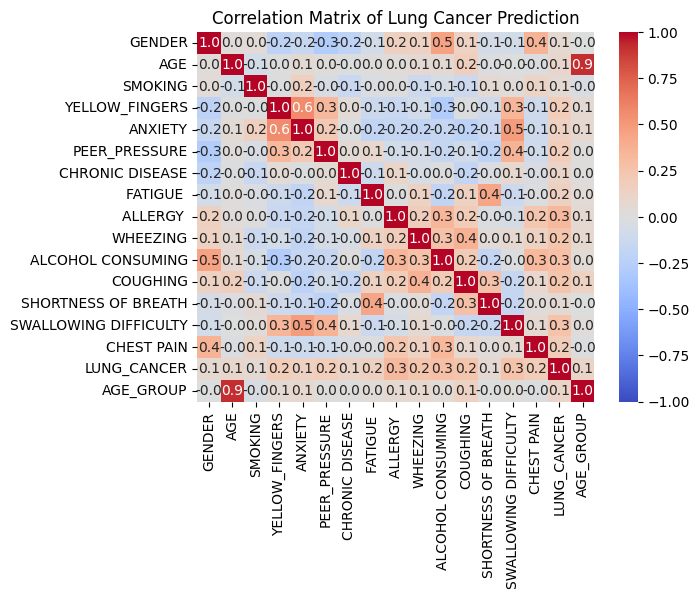

In [39]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.1f')
plt.title("Correlation Matrix of Lung Cancer Prediction")
plt.show()

In [41]:
luc_corr=df.corr()
luc_corr["LUNG_CANCER"].round(2)

GENDER                   0.07
AGE                      0.09
SMOKING                  0.06
YELLOW_FINGERS           0.18
ANXIETY                  0.14
PEER_PRESSURE            0.19
CHRONIC DISEASE          0.11
FATIGUE                  0.15
ALLERGY                  0.33
WHEEZING                 0.25
ALCOHOL CONSUMING        0.29
COUGHING                 0.25
SHORTNESS OF BREATH      0.06
SWALLOWING DIFFICULTY    0.26
CHEST PAIN               0.19
LUNG_CANCER              1.00
AGE_GROUP                0.11
Name: LUNG_CANCER, dtype: float64

In [29]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
print('LightGBM Version: ', lgb.__version__)

LightGBM Version:  4.5.0


In [30]:
df['LUNG_CANCER'] = df['LUNG_CANCER'].astype('category')
df['AGE_GROUP'] = df['AGE_GROUP'].astype('category')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df, df['LUNG_CANCER'], test_size=0.2, random_state=CFG.SEED)

In [32]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

#########################
### Fold 1
### train size 144, valid size 103
#########################
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1022]	valid_0's binary_logloss: 0.00318435
Accuracy for LightGBM =  1.0
F1 Score for LightGBM =  1.0


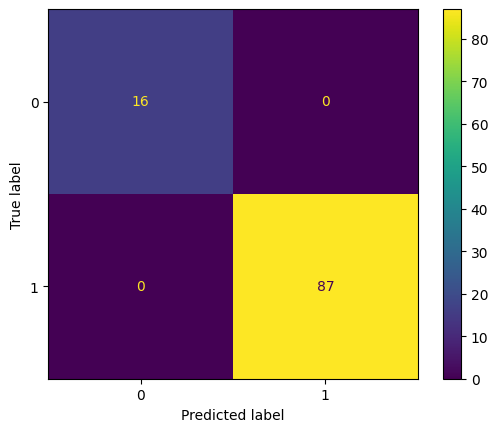

#########################
### Fold 2
### train size 158, valid size 89
#########################
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1022]	valid_0's binary_logloss: 0.00305988
Accuracy for LightGBM =  1.0
F1 Score for LightGBM =  1.0


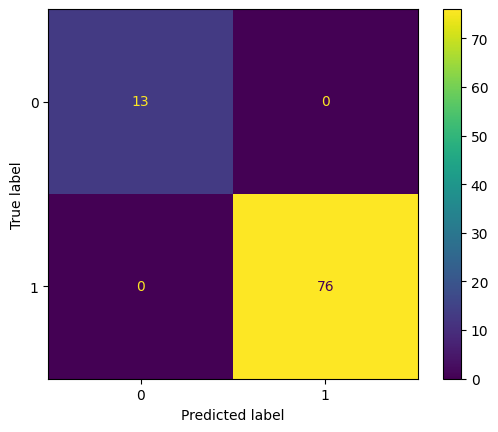

#########################
### Fold 3
### train size 204, valid size 43
#########################
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1022]	valid_0's binary_logloss: 0.00184976
Accuracy for LightGBM =  1.0
F1 Score for LightGBM =  1.0


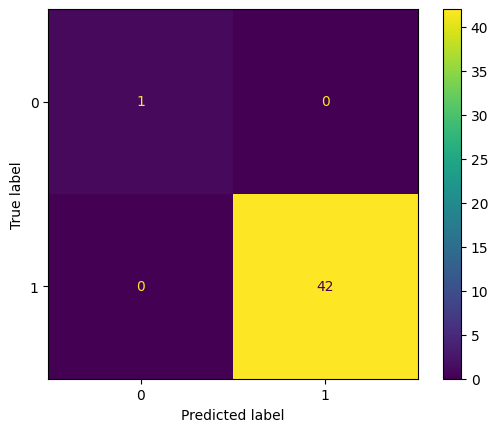

#########################
### Fold 4
### train size 235, valid size 12
#########################
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1022]	valid_0's binary_logloss: 0.00155215
Accuracy for LightGBM =  1.0
F1 Score for LightGBM =  1.0


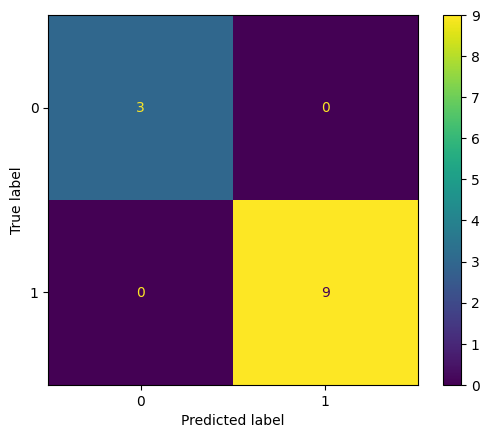

Accuracy for LightGBM =  1.0
F1 Score for LightGBM =  1.0


In [33]:
all_oof = []
all_true = []
    
gkf = GroupKFold(n_splits=4)
for i, (train_index, valid_index) in enumerate(gkf.split(X_train, y_train, X_train['AGE_GROUP'])):
      
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
                              
    model = lgb.LGBMClassifier(
                objective = 'binary',
                metrics = 'binary_logloss',
                learning_rate = 0.05,
                colsample_bytree = 0.8, 
                max_depth = 7, 
                num_leaves = 10, 
                reg_alpha = 0.2,
                reg_lambda = 0.8,
                n_estimators = 1024,
                class_weight='balanced',
                random_state=CFG.SEED,
                verbosity = - 1)
                                               
    train_x = X_train.loc[train_index]
    train_y = y_train.loc[train_index]
                                               
    valid_x = X_train.loc[valid_index]
    valid_y = y_train.loc[valid_index]
    
    model.fit(train_x, train_y,
                  eval_set = [(valid_x, valid_y)],
                  eval_metric = 'Accuracy',
                  callbacks = [early_stopping(stopping_rounds=100)]
               )
    
    # Save Model
    pickle.dump(model, open(f'LGB_v{CFG.VER}_f{i}.pkl', 'wb'))
      
    oof = model.predict(valid_x, num_iteration=model.best_iteration_)
    all_oof.append(oof)
    all_true.append(valid_y.values)
    
    accuracy = accuracy_score(valid_y.values, oof)
    f1 = f1_score(valid_y.values, oof, average='weighted')
    print('Accuracy for LightGBM = ',accuracy)
    print('F1 Score for LightGBM = ', f1)
    cm = confusion_matrix(valid_y.values, oof, labels=[x for x in range(2)])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(2)])
    disp.plot()
    plt.show()
      
    del train_x,train_y,valid_x,valid_y, oof, model
                                           
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

accuracy = accuracy_score(true[0], oof[0])
f1 = f1_score(true[0], oof[0], average='weighted')
print('Accuracy for LightGBM = ',accuracy)
print('F1 Score for LightGBM = ', f1)

In [34]:
if CFG.LOAD_MODELS_FROM:
    model = pickle.load(open(f'{CFG.LOAD_MODELS_FROM}LGB_v{CFG.VER}_f0.pkl', 'rb'))
else: 
    model = pickle.load(open(f'LGB_v{CFG.VER}_f0.pkl', 'rb'))

df_importance = pd.DataFrame({
        'features_name': df.columns,
        'importance': model.feature_importances_,
    })
df_importance

,features_name,importance
0,GENDER,0
1,AGE,2
2,SMOKING,0
3,YELLOW_FINGERS,1
4,ANXIETY,0
5,PEER_PRESSURE,16
6,CHRONIC DISEASE,6
7,FATIGUE,13
8,ALLERGY,11
9,WHEEZING,13


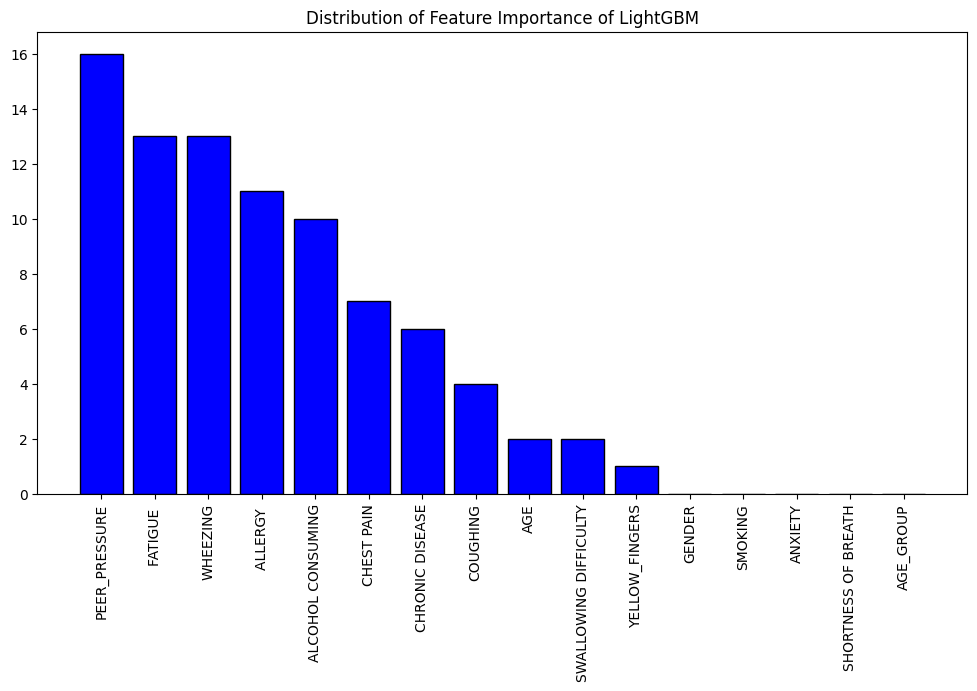

In [35]:
if CFG.LOAD_MODELS_FROM:
    model = pickle.load(open(f'{CFG.LOAD_MODELS_FROM}LGB_v{CFG.VER}_f0.pkl', 'rb'))
else: 
    model = pickle.load(open(f'LGB_v{CFG.VER}_f0.pkl', 'rb'))

df_importance = pd.DataFrame({
        'features_name': df.columns,
        'importance': model.feature_importances_,
    })
df_importance = df_importance[df_importance['features_name'] != 'LUNG_CANCER']

df_importance = df_importance.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
plt.bar(data=df_importance, x='features_name', height='importance', color='blue', edgecolor='black')
plt.title('Distribution of Feature Importance of LightGBM')
plt.xticks(rotation=90)
plt.show()

In [36]:
## Test
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [37]:
preds = []

for i in range(4):
    print(f'Fold {i+1}')
    if CFG.LOAD_MODELS_FROM:
        model = pickle.load(open(f'{CFG.LOAD_MODELS_FROM}LGB_v{CFG.VER}_f{i}.pkl', 'rb'))
    else: 
        model = pickle.load(open(f'LGB_v{CFG.VER}_f{i}.pkl', 'rb'))
        
    pred = model.predict(X_test)
    preds.append(pred)
pred = np.mean(preds,axis=0)       

Fold 1
Fold 2
Fold 3
Fold 4


In [38]:
accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted')
print('Accuracy for LightGBM = ',accuracy)
print('F1 Score for LightGBM = ', f1)

Accuracy for LightGBM =  1.0
F1 Score for LightGBM =  1.0
